# Recurrent Neural Networks

- A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes can create a cycle, allowing output from some nodes to affect subsequent input to the same nodes. This allows it to exhibit temporal dynamic behavior. 
- Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.
- A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data. 
- These deep learning algorithms are commonly used for ordinal or temporal problems, such as language translation, natural language processing (nlp), speech recognition, and image captioning

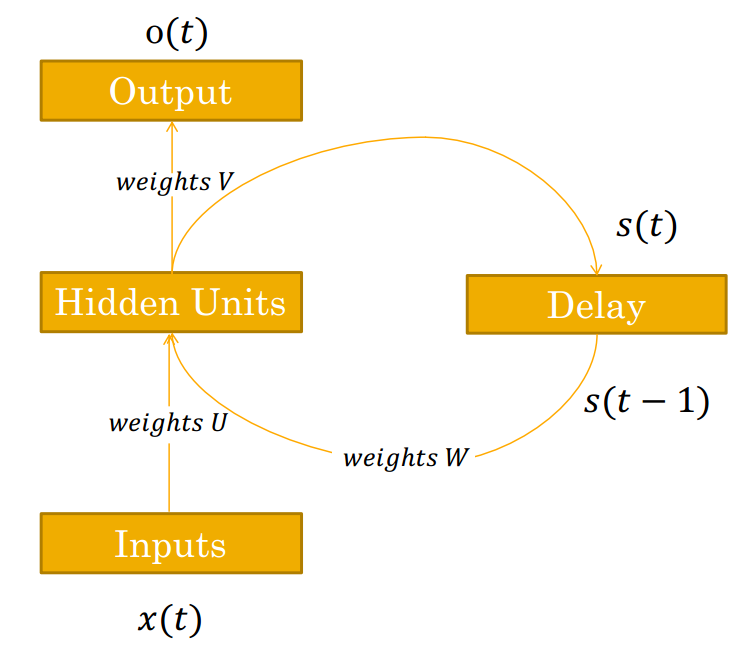

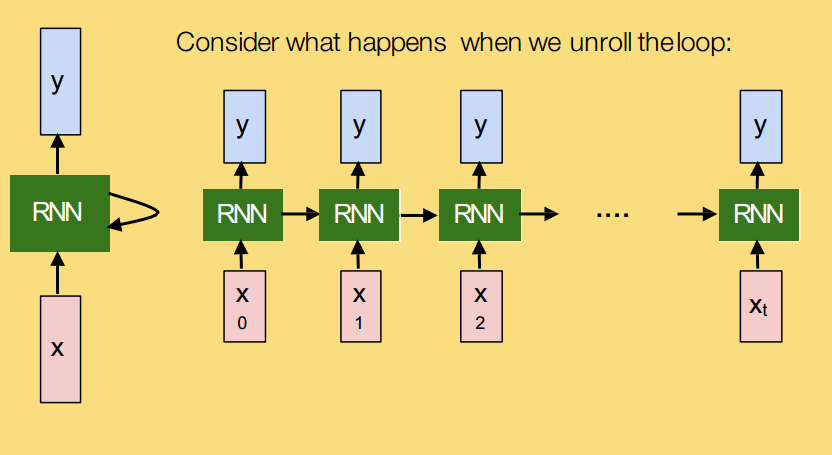

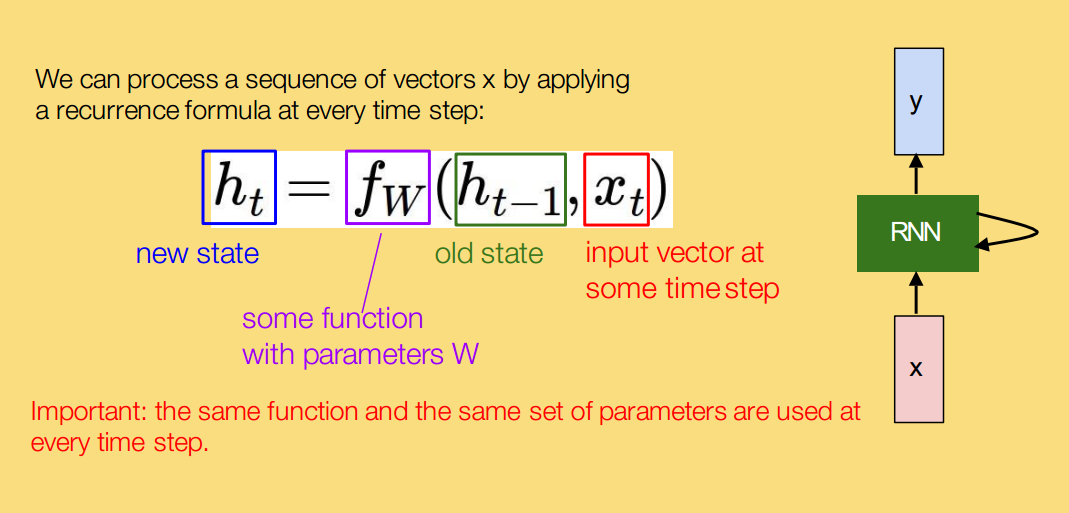

#### Upload the given dataset first

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt']
Slusarski


In [ ]:
all_letters, all_categories

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'",
 ['Greek',
  'Polish',
  'English',
  'Arabic',
  'Korean',
  'Spanish',
  'German',
  'Portuguese',
  'Vietnamese',
  'Irish',
  'Russian',
  'French',
  'Dutch',
  'Czech',
  'Italian',
  'Japanese',
  'Chinese',
  'Scottish'])



* To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
* To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.






In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).cuda()

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Verona
category = Vietnamese / line = Trieu
category = Arabic / line = Aswad
category = Czech / line = Hrabak
category = Chinese / line = Fan
category = Chinese / line = Guo
category = French / line = Lecuyer
category = Chinese / line = Thean
category = Russian / line = Porokhov
category = Spanish / line = Gonzalez


In [ ]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(),lr= learning_rate)

In [ ]:
def train(category_tensor, line_tensor,optimizer):
    hidden = rnn.initHidden()
    line_tensor = line_tensor.cuda()
    hidden = hidden.cuda()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor,optimizer)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 3.8234 Ballalatak / Dutch ✗ (Czech)
10000 10% (0m 20s) 2.1046 Ferreiro / Spanish ✗ (Portuguese)
15000 15% (0m 30s) 1.2174 Sun / Chinese ✗ (Korean)
20000 20% (0m 40s) 2.5026 Ajdrna / Spanish ✗ (Czech)
25000 25% (0m 51s) 0.2515 Garofalis / Greek ✓
30000 30% (1m 1s) 1.8902 Toma / Japanese ✗ (Arabic)
35000 35% (1m 12s) 1.0978 Mcgregor / Scottish ✓
40000 40% (1m 22s) 0.6249 Arriola / Spanish ✓
45000 45% (1m 32s) 1.1071 Schroder / German ✓
50000 50% (1m 43s) 0.9513 Mckay / Scottish ✓
55000 55% (1m 53s) 0.0428 Malinowski / Polish ✓
60000 60% (2m 3s) 1.2031 Vernon / English ✓
65000 65% (2m 14s) 1.8133 Blober / German ✗ (Czech)
70000 70% (2m 24s) 1.2423 Linford / English ✓
75000 75% (2m 34s) 1.0759 Doan / Vietnamese ✓
80000 80% (2m 44s) 0.8440 Couture / French ✓
85000 85% (2m 54s) 0.9566 Mushashibo / Japanese ✓
90000 90% (3m 4s) 1.0806 Peter / Dutch ✓
95000 95% (3m 15s) 0.6663 Rim / Korean ✓
100000 100% (3m 25s) 1.6916 Santiago / Portuguese ✗ (Spanish)


In [ ]:
line_tensor.shape

torch.Size([6, 1, 57])

In [ ]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])



In [ ]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.76) Russian
(-1.02) Czech
(-2.51) English

> Jackson
(-0.40) Scottish
(-1.60) English
(-3.23) Russian

> Satoshi
(-0.93) Italian
(-1.33) Japanese
(-1.98) Polish


### PyTorch RNN

torch.nn.RNN

- input_size – The number of expected features in the input x

- hidden_size – The number of features in the hidden state h

- num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

